<a href="https://colab.research.google.com/github/wael-slimi/Speciality_Recommedation/blob/main/Speciality_Recommedation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split , GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

## import dataset

In [3]:
df=pd.read_csv('archive/Original_Dataset.csv')
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


In [5]:
symptoms = []

for i in range(len(df)):
    value = df.iloc[i].values.tolist()
    if 0 in value:
        symptoms.append(value[1:value.index(0)])
    else:
        symptoms.append(value[1:])

df["Symptoms"] = symptoms
##print(df[['Disease', 'Symptoms']])
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,Symptoms
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, nodal_skin_eruptions, ..."
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[ skin_rash, nodal_skin_eruptions, dischromi..."
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, nodal_skin_eruptions, dischromic _..."
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, dischromic _patches, na..."
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[itching, skin_rash, nodal_skin_eruptions, n..."


In [6]:
import pandas as pd

column_values = df[['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4',
       'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9',
       'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14',
       'Symptom_15', 'Symptom_16', 'Symptom_17']].values.ravel()

symps = pd.unique(column_values).tolist()
symps = [i for i in symps if str(i) != "nan"]
print(symps)

new_data = pd.DataFrame(0, columns=symps, index=df.index)
new_data["Disease"] = df["Disease"]

for col in symps:
    new_data[col] = df['Symptoms'].apply(lambda x: 1 if col in x else 0)

new_data.head()


['itching', ' skin_rash', ' nodal_skin_eruptions', ' dischromic _patches', ' continuous_sneezing', ' shivering', ' chills', ' watering_from_eyes', ' stomach_pain', ' acidity', ' ulcers_on_tongue', ' vomiting', ' cough', ' chest_pain', ' yellowish_skin', ' nausea', ' loss_of_appetite', ' abdominal_pain', ' yellowing_of_eyes', ' burning_micturition', ' spotting_ urination', ' passage_of_gases', ' internal_itching', ' indigestion', ' muscle_wasting', ' patches_in_throat', ' high_fever', ' extra_marital_contacts', ' fatigue', ' weight_loss', ' restlessness', ' lethargy', ' irregular_sugar_level', ' blurred_and_distorted_vision', ' obesity', ' excessive_hunger', ' increased_appetite', ' polyuria', ' sunken_eyes', ' dehydration', ' diarrhoea', ' breathlessness', ' family_history', ' mucoid_sputum', ' headache', ' dizziness', ' loss_of_balance', ' lack_of_concentration', ' stiff_neck', ' depression', ' irritability', ' visual_disturbances', ' back_pain', ' weakness_in_limbs', ' neck_pain', ' 

,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,continuous_sneezing,shivering,chills,watering_from_eyes,stomach_pain,acidity,...,foul_smell_of urine,continuous_feel_of_urine,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Disease
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


In [7]:
X = new_data.drop('Disease', axis=1)
y = new_data['Disease']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [10]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({'Class': model.classes_,
                           'Precision': precision,
                           'Recall': recall,
                           'F1-score': f1})

print(metrics_df)


                                      Class  Precision  Recall  F1-score
0   (vertigo) Paroymsal  Positional Vertigo        1.0     1.0       1.0
1                                      AIDS        1.0     1.0       1.0
2                                      Acne        1.0     1.0       1.0
3                       Alcoholic hepatitis        1.0     1.0       1.0
4                                   Allergy        1.0     1.0       1.0
5                                 Arthritis        1.0     1.0       1.0
6                          Bronchial Asthma        1.0     1.0       1.0
7                      Cervical spondylosis        1.0     1.0       1.0
8                               Chicken pox        1.0     1.0       1.0
9                       Chronic cholestasis        1.0     1.0       1.0
10                              Common Cold        1.0     1.0       1.0
11                                   Dengue        1.0     1.0       1.0
12                                Diabetes         

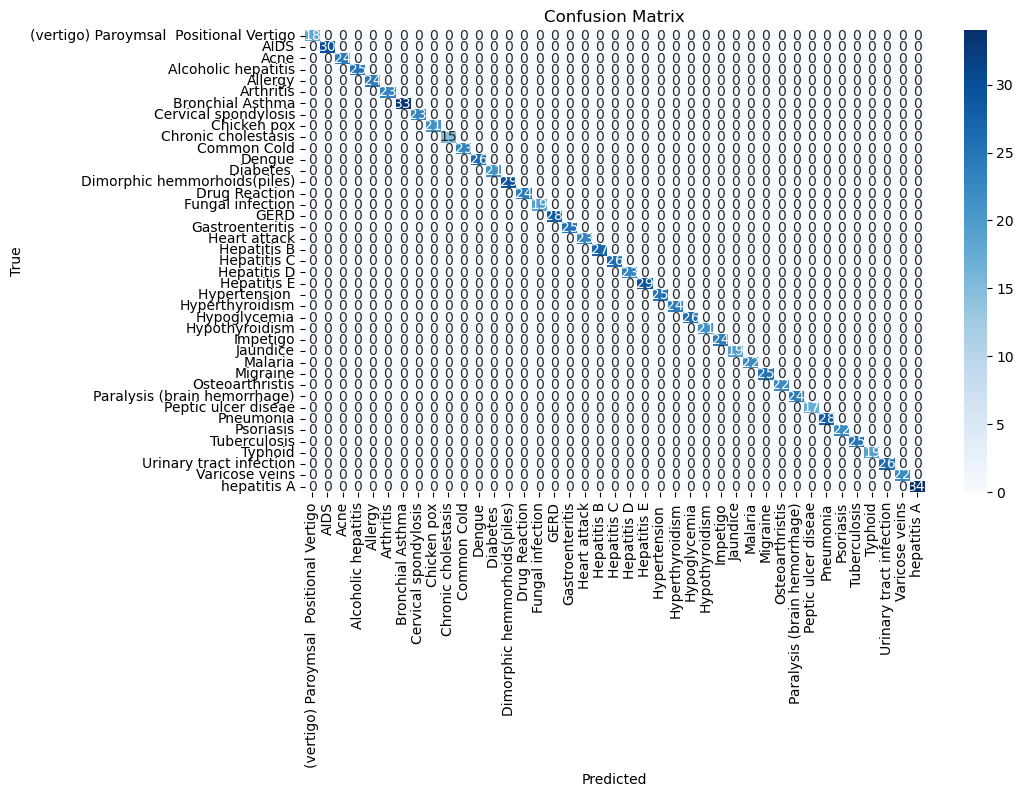

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds for cross-validation
k_folds = 5

# Initialize KFold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_accuracy = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Print the accuracy for each fold
print("Cross-Validation Accuracy for each fold:")
for i, accuracy in enumerate(cv_accuracy, 1):
    print(f"Fold {i}: {accuracy}")

# Calculate the mean and standard deviation of the cross-validation accuracy
mean_cv_accuracy = cv_accuracy.mean()
std_cv_accuracy = cv_accuracy.std()
print(f"\nMean Cross-Validation Accuracy: {mean_cv_accuracy}")
print(f"Standard Deviation of Cross-Validation Accuracy: {std_cv_accuracy}")


Cross-Validation Accuracy for each fold:
Fold 1: 1.0
Fold 2: 1.0
Fold 3: 1.0
Fold 4: 1.0
Fold 5: 1.0

Mean Cross-Validation Accuracy: 1.0
Standard Deviation of Cross-Validation Accuracy: 0.0


In [19]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from sklearn.linear_model import LogisticRegression



symptom_checkboxes = [widgets.Checkbox(value=False, description=symptom) for symptom in symps]


submit_button = widgets.Button(description='Diagnose')


output = widgets.Output()

def on_button_click(b):

    selected_symptoms = [symptom for symptom, checkbox in zip(symps, symptom_checkboxes) if checkbox.value]
    
    # Create a new data point for prediction
    input_data = pd.DataFrame(0, columns=symps, index=[0])
    for symptom in selected_symptoms:
        input_data[symptom] = 1

    # Predict the disease
    prediction = model.predict(input_data)
    
    # Display the prediction result
    with output:
        output.clear_output()
        print(f'Diagnosed Disease: {prediction[0]}')


submit_button.on_click(on_button_click)

# Display the checkboxes and button
display(widgets.VBox(symptom_checkboxes), submit_button, output)


Button(description='Diagnose', style=ButtonStyle())

Output()